### Load required packages

In [1]:
import os
import warnings
import scvi
import anndata
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
%matplotlib inline

sc.settings.n_jobs = 32
warnings.filterwarnings("ignore")

pwd = os.getcwd()

Global seed set to 0


### Retrieve new label_transfer cell barcodes (save for later usage, no need to redo).

In [2]:
ad = anndata.read_h5ad(filename="multivi_AD_3cohorts_RNA_ATAC_Multiome_v2.0_annotation_updated_refined_1.0.h5ad")

In [3]:
ad.obs.to_csv("multivi_AD_3cohorts_RNA_ATAC_Multiome_v2.0_annotation_updated_refined_1.0_obs_meta.csv")

In [5]:
# mvi_anno = pd.read_csv("multivi_AD_3cohorts_RNA_ATAC_Multiome_v2.0_annotation_updated_refined_1.0_obs_meta.csv")

### Prepare singleome ATAC and multiome dataset 

In [2]:
# Preprocess and load subclass specific peak matrix from multiome/ATAC.
def create_atac_anndata_specific(base_path, mtx_fl, peak_fl, barcode_fl):
    adata = anndata.read_mtx(os.path.join(base_path, mtx_fl))
    coords = pd.read_csv(
        os.path.join(base_path, peak_fl),
        sep="\t",
        header=None,
        index_col=None,
    )
    coords.rename({0: "chr", 1: "start", 2: "end"}, axis="columns", inplace=True)
    coords.set_index(
        coords.chr.astype(str)
        + ":"
        + coords.start.astype(str)
        + "-"
        + coords.end.astype(str),
        inplace=True,
    )
    coords.index = coords.index.astype(str)
    
    cell_annot = pd.read_csv(
        os.path.join(base_path, barcode_fl), 
        sep="-1_", 
        header=None, 
        index_col=None
    )
    cell_annot.rename({0: "barcode", 1: "library_prep"}, axis="columns", inplace=True)
    cell_annot["barcode"] = cell_annot["barcode"] + "-" + cell_annot["library_prep"]
    cell_annot.set_index("barcode", inplace=True)
    cell_annot.index = cell_annot.index.astype(str)
    
    adata.obs = cell_annot
    # adata.obs["modality"] = "accessibility"
    adata.var = coords
    adata.var["modality"] = "Peaks"
    return adata.copy()


In [3]:
# Preprocess and merge multiome-rna and multiome-atac datasets.
base_path = "/allen/programs/celltypes/workgroups/hct/SEA-AD/Integration/subclasses_files/"
mtx_fl = "counts_merge_subclassMicro-PVM_allpeaks.bed_counts.mtx"
peak_fl = "counts_merge_subclassMicro-PVM_allpeaks.bed_peaks.bed"
barcode_fl = "counts_merge_subclassMicro-PVM_allpeaks.bed_barcodes.tsv"

adata_atac = create_atac_anndata_specific(base_path, mtx_fl, peak_fl, barcode_fl)

In [4]:
adata_mult_atac = adata_atac[adata_atac.obs['library_prep'].str.contains('L8XR')].copy()

In [5]:
adata_atac_only = adata_atac[~adata_atac.obs['library_prep'].str.contains('L8XR')].copy()

In [6]:
adata_mult_rna = anndata.read_h5ad(filename="AD_3cohorts_MultiomeRNA_anndata.h5ad")

In [7]:
adata_mult_rna.var["modality"] = "Gene Expression"

In [8]:
cells = np.intersect1d(adata_mult_rna.obs.index, adata_mult_atac.obs.index, assume_unique=True)

In [9]:
adata_mult_atac = adata_mult_atac[cells, :].copy()
adata_mult_rna = adata_mult_rna[cells, :].copy()

In [10]:
adata_mult_rna = adata_mult_rna[adata_mult_rna.obs.index.argsort(), :].copy()
adata_mult_atac = adata_mult_atac[adata_mult_atac.obs.index.argsort(), :].copy()

In [11]:
sum(adata_mult_atac.obs.index != adata_mult_rna.obs.index)

0

In [12]:
adata_mult = anndata.concat([adata_mult_rna, adata_mult_atac], axis=1, join="inner", merge="unique")

In [13]:
del adata_mult_atac
del adata_mult_rna

In [88]:
mvi_anno = pd.read_csv("multivi_AD_3cohorts_RNA_ATAC_Multiome_v2.0_annotation_updated_refined_1.0_obs_meta.csv")
mvi_anno = mvi_anno[mvi_anno["label_transfer"].isin(['Micro-PVM'])]
mvi_anno[:3]

,Unnamed: 0,sample_id,batch_id,modality,_scvi_batch,_scvi_labels,donor_name,external_donor_name,age,sex,...,Doublet_or_LowQuality,rna_neighbors_qc_ratio,modality_mixing_ratio,subclass_purity_ratio,label_transfer,leiden_1.0,rna_neighbors_qc_ratio_new,all_neighbors_NA,subclass_purity_ratio_new,label_transfer_new
4,AAACAGCCAACAACAA-L8XR_210902_02_B08_paired,AAACAGCCAACAACAA-L8XR_210902_02_B08-1131257169,1.0,paired,2,0,H20.33.004,UWA 7028,86 yrs,Male,...,RNA high quality cells or ATAC cells,0.000000,1.304212,1.0,Micro-PVM,12,0.000000,0.0,1.0,Micro-PVM
62,AAACAGCCATAATCAC-L8XR_210902_02_D08_paired,AAACAGCCATAATCAC-L8XR_210902_02_D08-1131257170,1.0,paired,2,0,H20.33.038,UWA 7153,90 yrs,Female,...,RNA doublet or LQ cells,0.071429,1.897036,1.0,Micro-PVM,12,0.071429,0.0,1.0,Micro-PVM
63,AAACAGCCATAGCAGG-L8XR_210916_02_B11_paired,AAACAGCCATAGCAGG-L8XR_210916_02_B11-1131607954,1.0,paired,2,0,H21.33.003,UWA 7182,78 yrs,Male,...,RNA high quality cells or ATAC cells,0.055556,0.993686,1.0,Micro-PVM,12,0.055556,0.0,1.0,Micro-PVM


In [57]:
cells = np.intersect1d(adata_mult.obs["sample_id"], mvi_anno["sample_id"], assume_unique=True)

In [58]:
print(mvi_anno.shape)
print(mvi_anno[mvi_anno.modality == "paired"].shape)
print(adata_mult.shape)
print(cells.shape)

(12679, 425)
(3328, 425)
(3860, 150634)
(3052,)


In [59]:
adata_mult = adata_mult[adata_mult.obs["sample_id"].isin(cells)].copy()
print(adata_mult.shape)

(3052, 150634)


In [61]:
adata_atac_only.obs[:3]

,library_prep
barcode,
TTGTTGTAGTCGCCTG-L8AT_210916_01_B08,L8AT_210916_01_B08
TTGCGAAAGAGTGGAA-L8AT_210916_01_B08,L8AT_210916_01_B08
GGTAGGATCATTCTTG-L8AT_210916_01_B08,L8AT_210916_01_B08


In [65]:
mvi_atac = mvi_anno[mvi_anno.modality == "accessibility"]
mvi_atac[:3]

,Unnamed: 0,sample_id,batch_id,modality,_scvi_batch,_scvi_labels,donor_name,external_donor_name,age,sex,...,Doublet_or_LowQuality,rna_neighbors_qc_ratio,modality_mixing_ratio,subclass_purity_ratio,label_transfer,leiden_1.0,rna_neighbors_qc_ratio_new,all_neighbors_NA,subclass_purity_ratio_new,label_transfer_new
245728,AAAGATGAGCACCATT-L8AT_210916_01_B08_accessibility,AAAGATGAGCACCATT-L8AT_210916_01_B08-1131409693,1.0,accessibility,0,0,H21.33.003,NaN,78 yrs,Male,...,RNA high quality cells or ATAC cells,0.0,1.162700,1.0,Micro-PVM,12,0.0,0.0,1.0,Micro-PVM
245784,AACAAAGTCCAAGAGG-L8AT_210916_01_B08_accessibility,AACAAAGTCCAAGAGG-L8AT_210916_01_B08-1131409693,1.0,accessibility,0,0,H21.33.003,NaN,78 yrs,Male,...,RNA high quality cells or ATAC cells,0.0,0.542010,1.0,Micro-PVM,12,0.0,0.0,1.0,Micro-PVM
245824,AACCTGAGTGCATTCA-L8AT_210916_01_B08_accessibility,AACCTGAGTGCATTCA-L8AT_210916_01_B08-1131409693,1.0,accessibility,0,0,H21.33.003,NaN,78 yrs,Male,...,RNA high quality cells or ATAC cells,0.0,1.422777,1.0,Micro-PVM,12,0.0,0.0,1.0,Micro-PVM


In [64]:
mvi_atac_cells = mvi_atac["Unnamed: 0"].str.replace("_accessibility", "")

245728    AAAGATGAGCACCATT-L8AT_210916_01_B08
245784    AACAAAGTCCAAGAGG-L8AT_210916_01_B08
245824    AACCTGAGTGCATTCA-L8AT_210916_01_B08
245848    AACGAGGGTTCTACGA-L8AT_210916_01_B08
245885    AACTGGTGTGATGCTT-L8AT_210916_01_B08
                         ...                 
825534    TCACTCGTCAGTGTGT-L8AT_211117_01_F07
825585    TGAGTCAAGGTACATA-L8AT_211117_01_F07
825586    TGAGTCACAATCACTG-L8AT_211117_01_F07
825612    TGCGTAATCACGTCAA-L8AT_211117_01_F07
825633    TGGCGCAGTCGATAGG-L8AT_211117_01_F07
Name: Unnamed: 0, Length: 6564, dtype: object

In [66]:
cells = np.intersect1d(adata_atac_only.obs.index, mvi_atac_cells, assume_unique=True)
print(mvi_atac.shape)
print(adata_atac_only.shape)
print(cells.shape)

(6564, 425)
(8043, 114033)
(6326,)


In [67]:
adata_atac_only = adata_atac_only[cells, :].copy()
print(adata_atac_only.shape)

(6326, 114033)


### This session is unnecessary.
### Load in new annotations (RNA and Multiome) and update multiome dataset

In [14]:
# rna_mult_anno = pd.read_csv("/allen/programs/celltypes/workgroups/hct/SEA-AD/RNAseq/scANVI/output/MTG_AD/metadata/MTG_combined_metadata_full.2022-04-13.csv")
# ad_obs_m = adata_mult.obs.copy()
# ad_obs_m.reset_index(inplace=True)
# column_select = ['level_0']
# ad_obs_m_1 = ad_obs_m[column_select]
# ad_obs_m_2 = pd.merge(ad_obs_m_1, rna_mult_anno, how='left', left_on='level_0', right_on='index_name')
# ad_obs_m_2 = ad_obs_m_2.drop(['index_name'], axis=1)
# # to test if left join keeps original left df order.
# print("index/barcode orders that do not match between original and joined dataframes: ", sum(ad_obs_m_2.level_0 != ad_obs_m.level_0))
# ad_obs_m_2.set_index("level_0", inplace=True)
# ad_obs_m_2.index.name = None
# print(np.sum(adata_mult.obs.index != ad_obs_m_2.index))
# adata_mult.obs = ad_obs_m_2
# del adata_atac

### Prepare singleome RNA dataset

In [37]:
## use already generated cohort2 RNA only data for label transfer to ATAC (Mariano suggests this).
adata_rna_only = anndata.read_h5ad(filename="AD_cohort2_RNA_only_anndata.h5ad")

In [38]:
# ad_obs = adata_rna_only.obs.copy()
# ad_obs.reset_index(inplace=True)
# column_select = ['index_name']
# ad_obs_1 = ad_obs[column_select]
# ad_obs_2 = pd.merge(ad_obs_1, rna_mult_anno, how='left', on='index_name')
# # to test if left join keeps original left df order.
# print("index/barcode orders that do not match between original and joined dataframes: ", sum(ad_obs_2.index_name != ad_obs.index_name))
# ad_obs_2.set_index("index_name", inplace=True)
# print(np.sum(adata_rna_only.obs.index != ad_obs_2.index))
# adata_rna_only.obs = ad_obs_2

In [42]:
cells = np.intersect1d(adata_rna_only.obs["sample_id"], mvi_anno["sample_id"], assume_unique=True)

In [43]:
print(mvi_anno.shape)
print(mvi_anno[mvi_anno.modality == "expression"].shape)
print(adata_rna_only.shape)
print(cells.shape)

(12679, 425)
(2787, 425)
(160520, 36601)
(2787,)


In [52]:
adata_rna_only = adata_rna_only[adata_rna_only.obs["sample_id"].isin(cells)].copy()

In [68]:
print(adata_rna_only.shape)

(2787, 36601)


In [69]:
## add meta info for singleome ATAC datasets to avoid NAN in the model training.
# atac_only_anno = pd.read_csv("/allen/programs/celltypes/workgroups/rnaseqanalysis/ATAC-Seq/Arrow/ATAC_AD_Center_Grant_complete/ATAC_AD_Center_Grant_complete.csv")
## This file has been deleted and updated to "ATAC_AD_Center_Grant_update.csv" with two libraries removed. But our analysis was based on the old version.
## There is one copy of old file in my personal folder. Use it as a backup.

# atac_only_anno = pd.read_csv("/allen/programs/celltypes/workgroups/rnaseqanalysis/YiDing/Human_AD_MTG/ATAC_AD_Center_Grant_complete.csv")
# atac_only_anno = atac_only_anno.loc[:, ['age', 'sex', 'medical_conditions', 'donor_name', 'method', 'library_prep', 'external_donor_name']]
# print(atac_only_anno['sex'].unique())
# df = adata_atac_only.obs.copy()
# df.reset_index(inplace=True)
# df_new = pd.merge(df, atac_only_anno, how='left', on='library_prep')
# # to test if left join keeps original left df order.
# print("barcode orders that do not match between original and joined dataframes: ", sum(df_new.barcode != df.barcode))
# adata_atac_only.obs = df_new
# adata_atac_only.obs.set_index("barcode", inplace=True)

# print(sum(adata_atac_only.obs.donor_name.isnull()))
# print(sum(adata_atac_only.obs.sex.isnull()))
# print(sum(adata_mult.obs.donor_name.isnull()))
# print(sum(adata_mult.obs.sex.isnull()))
# print(sum(adata_rna_only.obs.donor_name.isnull()))
# print(sum(adata_rna_only.obs.sex.isnull()))

# del atac_only_anno
# del df
# del df_new

### Prepare MVI dataset and run MultiVI

In [85]:
# We can now use the organizing method from scvi to concatenate these anndata
adata_mvi = scvi.data.organize_multiome_anndatas(adata_mult, adata_rna_only, adata_atac_only)

In [86]:
# del adata_mult
# del adata_rna_only
# del adata_atac_only

In [87]:
adata_mvi.obs[:3]

,orig.ident,nCount_RNA,nFeature_RNA,sample_id,bc,ar_id,umi.counts,barcodes,gene.counts.0,gene.counts.1,...,Vip_23,Vip_4,Vip_5,Vip_6,Vip_9,supertype_scANVI,supertype_conf_scANVI,supertype_multiome_mask,supertype_singleome_mask,modality
AAACAGCCAACAACAA-L8XR_210902_02_B08_paired,SeuratProject,15759.0,4204.0,AAACAGCCAACAACAA-L8XR_210902_02_B08-1131257169,AAACAGCCAACAACAA,1.131257e+09,15759.0,AAACAGCCAACAACAA,4204.0,2368.0,...,0.0,0.0,0.0,0.0,0.0,Micro-PVM_1,1.0,,,paired
AAACAGCCATAATCAC-L8XR_210902_02_D08_paired,SeuratProject,22470.0,4974.0,AAACAGCCATAATCAC-L8XR_210902_02_D08-1131257170,AAACAGCCATAATCAC,1.131257e+09,22470.0,AAACAGCCATAATCAC,4974.0,2944.0,...,0.0,0.0,0.0,0.0,0.0,Micro-PVM_2,1.0,,,paired
AAACAGCCATAGCAGG-L8XR_210916_02_B11_paired,SeuratProject,5797.0,2634.0,AAACAGCCATAGCAGG-L8XR_210916_02_B11-1131607954,AAACAGCCATAGCAGG,1.131608e+09,5797.0,AAACAGCCATAGCAGG,2634.0,1143.0,...,0.0,0.0,0.0,0.0,0.0,Micro-PVM_2,1.0,,,paired


In [89]:
df = adata_mvi.obs.copy()
df.reset_index(inplace=True)
df = df[['level_0', 'modality']]

mvi_anno = mvi_anno.drop(['modality', 'batch_id', '_scvi_batch', '_scvi_labels'], axis=1)

df_new = pd.merge(df, mvi_anno, how='left', left_on='level_0', right_on='Unnamed: 0')
df_new = df_new.drop(['Unnamed: 0'], axis=1)

# to test if left join keeps original left df order.
print("barcode orders that do not match between original and joined dataframes: ", sum(df_new.level_0 != adata_mvi.obs.index))

barcode orders that do not match between original and joined dataframes:  0


In [90]:
df_new.set_index('level_0', inplace=True)
df_new.index.name = None
adata_mvi.obs = df_new
adata_mvi.obs[:3]

,modality,sample_id,donor_name,external_donor_name,age,sex,medical_conditions,method,library_prep,orig.ident,...,Doublet_or_LowQuality,rna_neighbors_qc_ratio,modality_mixing_ratio,subclass_purity_ratio,label_transfer,leiden_1.0,rna_neighbors_qc_ratio_new,all_neighbors_NA,subclass_purity_ratio_new,label_transfer_new
AAACAGCCAACAACAA-L8XR_210902_02_B08_paired,paired,AAACAGCCAACAACAA-L8XR_210902_02_B08-1131257169,H20.33.004,UWA 7028,86 yrs,Male,AD neuropathological change = 3 (high)_and_APO...,10xMulti,L8XR_210902_02_B08,SeuratProject,...,RNA high quality cells or ATAC cells,0.000000,1.304212,1.0,Micro-PVM,12,0.000000,0.0,1.0,Micro-PVM
AAACAGCCATAATCAC-L8XR_210902_02_D08_paired,paired,AAACAGCCATAATCAC-L8XR_210902_02_D08-1131257170,H20.33.038,UWA 7153,90 yrs,Female,AD neuropathological change = 3 (high)_and_APO...,10xMulti,L8XR_210902_02_D08,SeuratProject,...,RNA doublet or LQ cells,0.071429,1.897036,1.0,Micro-PVM,12,0.071429,0.0,1.0,Micro-PVM
AAACAGCCATAGCAGG-L8XR_210916_02_B11_paired,paired,AAACAGCCATAGCAGG-L8XR_210916_02_B11-1131607954,H21.33.003,UWA 7182,78 yrs,Male,AD neuropathological change = 0 (none)_and_APO...,10xMulti,L8XR_210916_02_B11,SeuratProject,...,RNA high quality cells or ATAC cells,0.055556,0.993686,1.0,Micro-PVM,12,0.055556,0.0,1.0,Micro-PVM


In [97]:
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
adata_mvi.var

,modality
MIR1302-2HG,Gene Expression
AL391261.2,Gene Expression
FUT8-AS1,Gene Expression
FUT8,Gene Expression
AL355076.2,Gene Expression
...,...
chr12:53213044-53214126,Peaks
chr12:53211892-53212004,Peaks
chr12:53208449-53209876,Peaks
chr12:53294661-53296119,Peaks


In [98]:
## Don't do cell removal (fewer than 1000 count in genes and peaks).
scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key='modality', categorical_covariate_keys=["donor_name", "sex"])

mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
)

INFO     Using batches from adata.obs["modality"]                                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 12165 cells, 150634 vars, 3       
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [99]:
mvi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 202/500:  40%|████████████████████▏                             | 202/500 [36:42<54:08, 10.90s/it, loss=8.73e+03, v_num=1]


In [100]:
convert_columns = ['experiment_component_failed',
 'class',
 'neighborhood',
 'subclass',
 'subclass_color',
 'cluster',
 'cluster_color',
 'class_held',
 'subclass_held',
 'cluster_held',
 'supertype',
 'for_analysis']

In [101]:
adata_mvi.obs[convert_columns] = adata_mvi.obs[convert_columns].astype(str)

In [102]:
mvi.save("trained_multivi_AD_3cohorts_RNA_ATAC_Multiome_v2.0_Microglia", save_anndata=True)

... storing 'modality' as categorical
... storing 'donor_name' as categorical
... storing 'external_donor_name' as categorical
... storing 'age' as categorical
... storing 'sex' as categorical
... storing 'medical_conditions' as categorical
... storing 'method' as categorical
... storing 'library_prep' as categorical
... storing 'orig.ident' as categorical
... storing 'bc' as categorical
... storing 'barcodes' as categorical
... storing 'exclude' as categorical
... storing 'exp_component_name' as categorical
... storing 'exp_component_vendor_name' as categorical
... storing 'batch_vendor_name' as categorical
... storing 'tube' as categorical
... storing 'tube_internal_name' as categorical
... storing 'r1_index' as categorical
... storing 'r2_index' as categorical
... storing 'index_sequence_pair' as categorical
... storing 'organism' as categorical
... storing 'facs_container' as categorical
... storing 'sample_name' as categorical
... storing 'cell_name' as categorical
... storing 'st

In [103]:
adata_mvi.obsm["X_MultiVI"] = mvi.get_latent_representation()
sc.pp.neighbors(adata_mvi, use_rep="X_MultiVI")
sc.tl.umap(adata_mvi, min_dist=0.2)

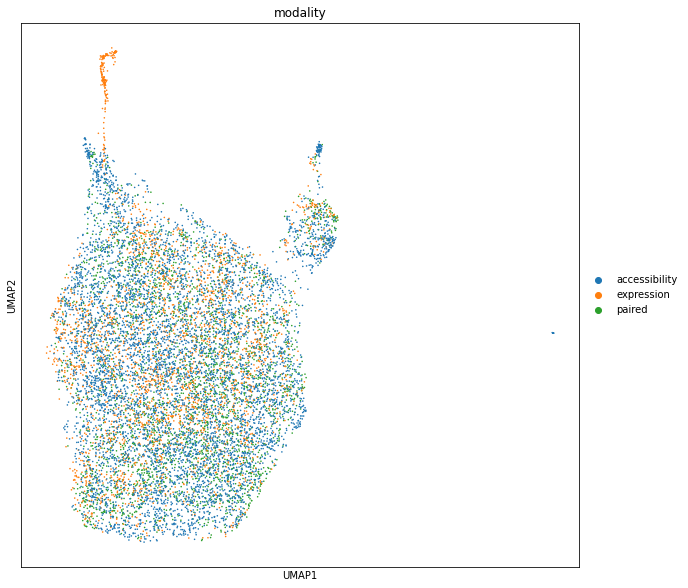

In [104]:
plt.rcParams["figure.figsize"] = (10, 10)
sc.pl.umap(adata_mvi, color='modality')

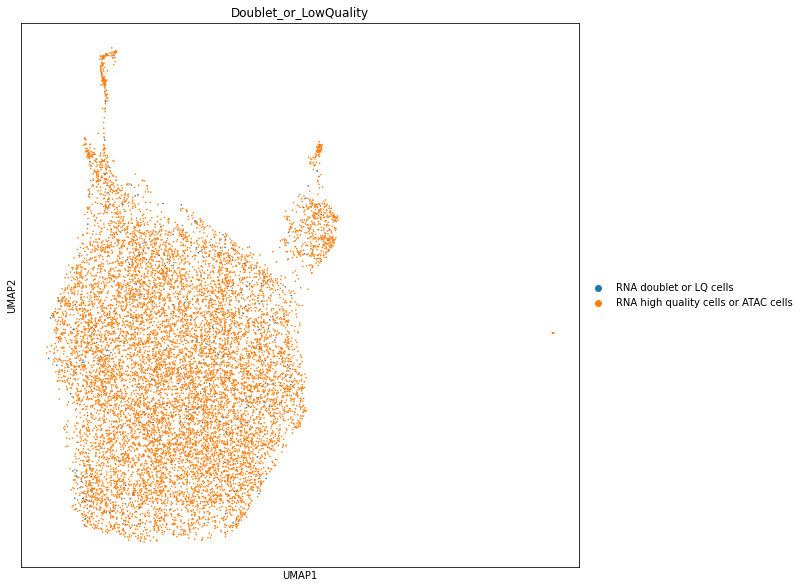

In [105]:
## 'for_analysis' has been converted to string! (because of saving errors with the mvi model)
sc.pl.umap(adata_mvi, color='Doublet_or_LowQuality')

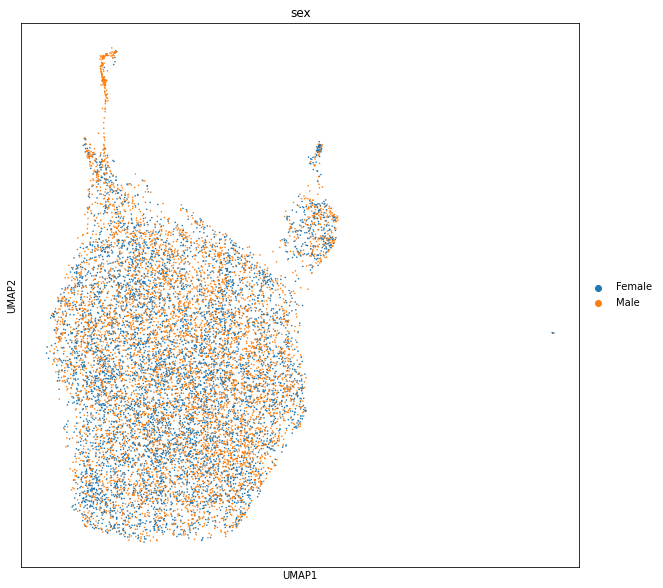

In [106]:
sc.pl.umap(adata_mvi, color='sex')

In [116]:
adata_mvi.obs.supertype_scANVI.unique()

['Micro-PVM_1', 'doublet_score', 'Micro-PVM_2', 'fraction_mito', 'cluster_doublet_score_flag', 'cluster_fraction_ribo_flag', 'cluster_fraction_mito_flag', 'n_genes', 'cluster_n_genes_flag', NaN]
Categories (9, object): ['Micro-PVM_1', 'Micro-PVM_2', 'cluster_doublet_score_flag', 'cluster_fraction_mito_flag', ..., 'cluster_n_genes_flag', 'doublet_score', 'fraction_mito', 'n_genes']

In [117]:
adata_mvi.obs.supertype_scANVI_leiden.unique()

['Micro-PVM_1', 'doublet_score', 'Micro-PVM_2', 'Micro-PVM_Unknown_9', 'Micro-PVM_Unknown_0', ..., 'Micro-PVM_Unknown_135', 'n_genes', 'cluster_n_genes_flag', 'Micro-PVM_Unknown_200', NaN]
Length: 16
Categories (15, object): ['Micro-PVM_1', 'Micro-PVM_2', 'Micro-PVM_Unknown_0', 'Micro-PVM_Unknown_9', ..., 'cluster_n_genes_flag', 'doublet_score', 'fraction_mito', 'n_genes']

In [120]:
def compute_label_purity_slot(adata_mvi, cell_idx, slot="subclass_scANVI"):
    idx = np.where(adata_mvi.uns['neighbors']['connectivities'][cell_idx].todense()>0)[1]
    df = adata_mvi.obs[[slot]].iloc[idx]
    df = df.loc[~df[slot].isnull()]
    u, c = np.unique(df, return_counts=True)
    if np.size(c) == 0:
        ratio = 0
        label = np.nan
    else:
        ratio = c[np.argmax(c)] / c.sum()
        label = u[np.argmax(c)]
    
    return ratio, label

In [121]:
cells = adata_mvi.shape[0]
purity_ratios = np.zeros(cells)
labels = adata_mvi.obs["supertype_scANVI"].to_numpy()
for i in np.arange(cells):
    ratio, label_ = compute_label_purity_slot(adata_mvi, i, slot="supertype_scANVI")
    purity_ratios[i] = ratio
    labels[i] = label_

adata_mvi.obs["supertype_scANVI_purity_ratio"] = purity_ratios
adata_mvi.obs["supertype_scANVI_label_transfer"] = labels

In [122]:
for i in np.where(adata_mvi.obs["supertype_scANVI_label_transfer"].isnull())[0]:
    ratio, label_ = compute_label_purity_slot(adata_mvi, i, slot="supertype_scANVI_label_transfer")
    adata_mvi.obs["supertype_scANVI_purity_ratio"].loc[i] = ratio
    adata_mvi.obs["supertype_scANVI_label_transfer"].loc[i] = label_

In [123]:
print(adata_mvi.obs["supertype_scANVI_label_transfer"].isnull().sum())

257


In [124]:
cells = adata_mvi.shape[0]
purity_ratios = np.zeros(cells)
labels = adata_mvi.obs["supertype_scANVI_leiden"].to_numpy()
for i in np.arange(cells):
    ratio, label_ = compute_label_purity_slot(adata_mvi, i, slot="supertype_scANVI_leiden")
    purity_ratios[i] = ratio
    labels[i] = label_

adata_mvi.obs["supertype_scANVI_leiden_purity_ratio"] = purity_ratios
adata_mvi.obs["supertype_scANVI_leiden_label_transfer"] = labels

In [125]:
for i in np.where(adata_mvi.obs["supertype_scANVI_leiden_label_transfer"].isnull())[0]:
    ratio, label_ = compute_label_purity_slot(adata_mvi, i, slot="supertype_scANVI_leiden_label_transfer")
    adata_mvi.obs["supertype_scANVI_leiden_purity_ratio"].loc[i] = ratio
    adata_mvi.obs["supertype_scANVI_leiden_label_transfer"].loc[i] = label_

In [126]:
print(adata_mvi.obs["supertype_scANVI_leiden_label_transfer"].isnull().sum())

257


... storing 'supertype_scANVI_label_transfer' as categorical
... storing 'supertype_scANVI_leiden_label_transfer' as categorical


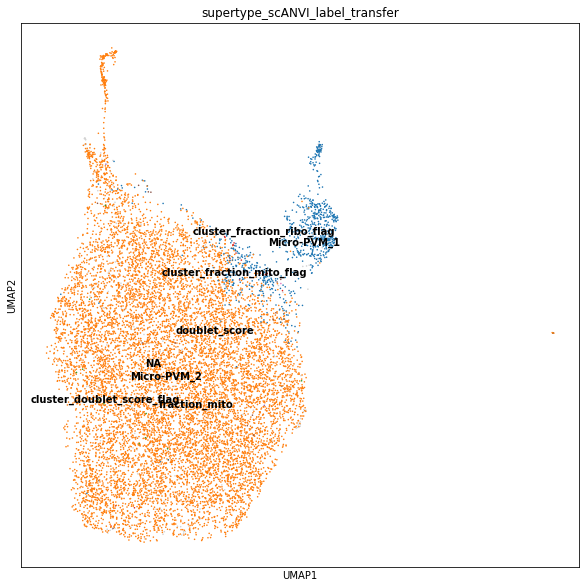

In [127]:
sc.pl.umap(adata_mvi, color='supertype_scANVI_label_transfer', legend_loc="on data")

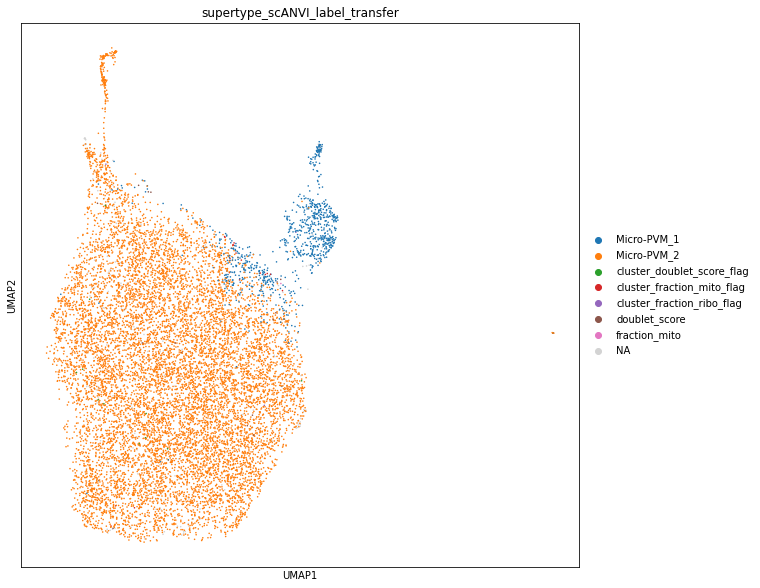

In [128]:
sc.pl.umap(adata_mvi, color='supertype_scANVI_label_transfer')

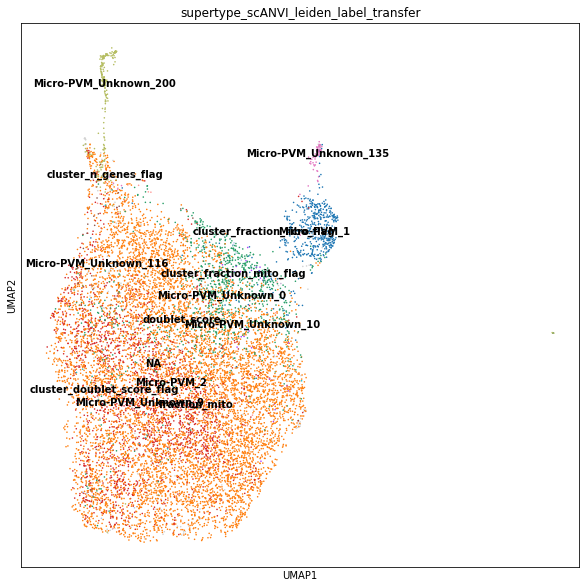

In [129]:
sc.pl.umap(adata_mvi, color='supertype_scANVI_leiden_label_transfer', legend_loc="on data")

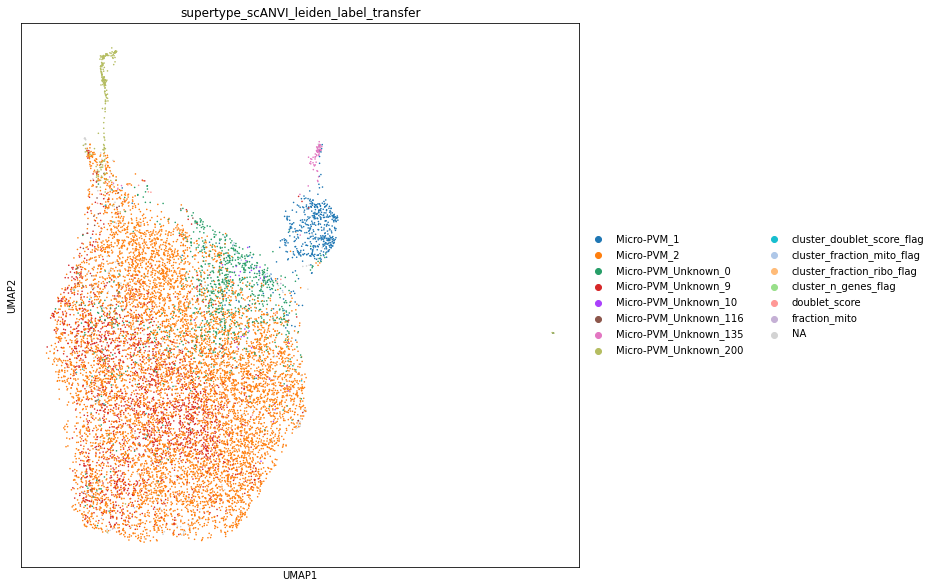

In [130]:
sc.pl.umap(adata_mvi, color='supertype_scANVI_leiden_label_transfer')

In [131]:
adata_mvi.write("multivi_AD_3cohorts_RNA_ATAC_Multiome_v2.0_Microglia.h5ad")